# 探索 GoBike 数据
## by Ivy

## 初步探索

> 该数据集包含有关在旧金山湾区的自行车共享系统中的单次骑行信息。下载地址为：https://s3.amazonaws.com/baywheels-data/index.html 。本次分析只下载了 2018 年 1 - 12 月的数据。每条信息都是匿名的，其中包括:
- 骑行时长
- 开始时间
- 结束时间
- 开始站点 ID
- 开始站点名称
- 开始站点纬度
- 开始站点经度
- 结束站点 ID
- 结束站点名称
- 结束站点纬度
- 结束站点经度
- 车辆 ID
- 用户类型：
    1. 会员："Subscriber" 或者 "Member"
    2. 散客："Customer" 或者 "Casual"
- 是否参与 Bike Share for All 计划

In [1]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import requests, zipfile, io

from parse_data import unzip_csv, append_csv # 自定义的脚本文件，用于处理 zip 数据集文件
pd.set_option('max_colwidth',200)
%matplotlib inline

> 2018 年数据集有多个，每个月一个 csv 文件，所以这里先把 2018 年的数据进行合并，创建一个新的 `2018-fordgobike-tripdata.csv` 数据集。

因为数据集太大，下载下来的是 zip 文件，初始需要运行以下代码获取完整数据：

In [2]:
# 解压 zip 文件为 csv 文件，并且将多个文件合并为一个
# 初次运行需要耐心等待一段时间
if '2018-fordgobike-tripdata.csv' not in os.listdir(): # 判断当前工作目录是否存在目标数据集
    # 下载链接列表
    urls = []
    for i in range(1,13):
        date = str(201800 + i)
        url = ('https://s3.amazonaws.com/baywheels-data/' + 
               date + '-fordgobike-tripdata.csv.zip')
        urls.append(url)
    
    csv_list = unzip_csv(urls) # 下载并解压所有 zip 文件
    df = append_csv(csv_list) # 将所有 csv 文件读取并合并到一个数据集
    df.to_csv('2018-fordgobike-tripdata.csv',index=False) # 保存为一个 2018 年的数据集
else:
    df = pd.read_csv('2018-fordgobike-tripdata.csv')

> 加载数据集，并通过以下问题描述数据属性。
尝试通过这部分内容获得探索灵感。

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1863721 entries, 0 to 131362
Data columns (total 14 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   duration_sec             int64  
 1   start_time               object 
 2   end_time                 object 
 3   start_station_id         float64
 4   start_station_name       object 
 5   start_station_latitude   float64
 6   start_station_longitude  float64
 7   end_station_id           float64
 8   end_station_name         object 
 9   end_station_latitude     float64
 10  end_station_longitude    float64
 11  bike_id                  int64  
 12  user_type                object 
 13  bike_share_for_all_trip  object 
dtypes: float64(6), int64(2), object(6)
memory usage: 213.3+ MB


In [4]:
# 每列数据的缺失值比例
df.isna().sum()/df.shape[0]

duration_sec               0.000000
start_time                 0.000000
end_time                   0.000000
start_station_id           0.006316
start_station_name         0.006316
start_station_latitude     0.000000
start_station_longitude    0.000000
end_station_id             0.006316
end_station_name           0.006316
end_station_latitude       0.000000
end_station_longitude      0.000000
bike_id                    0.000000
user_type                  0.000000
bike_share_for_all_trip    0.000000
dtype: float64

因为这个数据集的量非常大，缺失值比例都比较小，所以直接将所有包含缺失值的数据删除处理。

In [5]:
df.dropna(inplace=True)
df.shape[0]

1851950

In [6]:
df.head()

,duration_sec,start_time,end_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bike_id,user_type,bike_share_for_all_trip
0,75284,2018-01-31 22:52:35.2390,2018-02-01 19:47:19.8240,120.0,Mission Dolores Park,37.761420,-122.426435,285.0,Webster St at O'Farrell St,37.783521,-122.431158,2765,Subscriber,No
1,85422,2018-01-31 16:13:34.3510,2018-02-01 15:57:17.3100,15.0,San Francisco Ferry Building (Harry Bridges Plaza),37.795392,-122.394203,15.0,San Francisco Ferry Building (Harry Bridges Plaza),37.795392,-122.394203,2815,Customer,No
2,71576,2018-01-31 14:23:55.8890,2018-02-01 10:16:52.1160,304.0,Jackson St at 5th St,37.348759,-121.894798,296.0,5th St at Virginia St,37.325998,-121.877120,3039,Customer,No
3,61076,2018-01-31 14:53:23.5620,2018-02-01 07:51:20.5000,75.0,Market St at Franklin St,37.773793,-122.421239,47.0,4th St at Harrison St,37.780955,-122.399749,321,Customer,No
4,39966,2018-01-31 19:52:24.6670,2018-02-01 06:58:31.0530,74.0,Laguna St at Hayes St,37.776435,-122.426244,19.0,Post St at Kearny St,37.788975,-122.403452,617,Subscriber,No


初步清理各列错误的数据类型：

- id 相关列应该是字符串类型；
- time 相关列应该是 datetime 类型；
- bike_share_for_all_trip 应该是布尔值。

In [7]:
column_list = df.columns.tolist()

In [8]:
for c in column_list:
    if '_id' in c:
        df[c] = df[c].astype(np.int64).astype(str)
    elif '_time' in c:
        df[c] = pd.to_datetime(df[c])

In [9]:
df.replace(['Yes','No'],[True,False],inplace=True)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1851950 entries, 0 to 131362
Data columns (total 14 columns):
 #   Column                   Dtype         
---  ------                   -----         
 0   duration_sec             int64         
 1   start_time               datetime64[ns]
 2   end_time                 datetime64[ns]
 3   start_station_id         object        
 4   start_station_name       object        
 5   start_station_latitude   float64       
 6   start_station_longitude  float64       
 7   end_station_id           object        
 8   end_station_name         object        
 9   end_station_latitude     float64       
 10  end_station_longitude    float64       
 11  bike_id                  object        
 12  user_type                object        
 13  bike_share_for_all_trip  bool          
dtypes: bool(1), datetime64[ns](2), float64(4), int64(1), object(6)
memory usage: 199.6+ MB


### 数据集结构

- `duration_sec`               int64
- `start_time`                 datetime64[ns]
- `end_time`                   datetime64[ns]
- `start_station_id`           object
- `start_station_name`         object
- `start_station_latitude`     float64
- `start_station_longitude`    float64
- `end_station_id`             object
- `end_station_name`           object
- `end_station_latitude`       float64
- `end_station_longitude`      float64
- `bike_id`                    object
- `user_type`                  object
- `bike_share_for_all_trip`    bool

### 数据集中感兴趣的列主要有：

- 是否订阅会员服务（`user_type`），与哪些特征相关？

### 你认为数据集中的哪些特征有助于对感兴趣的特征进行探索？

> `duration_sec`、`start_time`  、`bike_share_for_all_trip`

## 单变量探索

> 对单一变量进行探索，如果发现异常值，则进行深入清理。

In [11]:
df_copy = df[['duration_sec','start_time','bike_share_for_all_trip','user_type']].copy()

#### 骑行时长分布

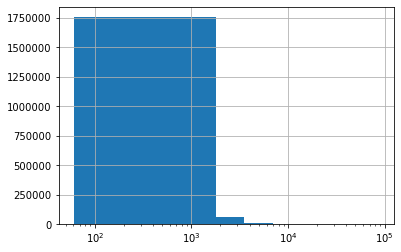

In [12]:
df_copy.duration_sec.hist(bins=50)
plt.xscale('log');

可以看到骑行时长右偏非常严重，使用 log 变换之后也不太容易观察，再详细设置一下：

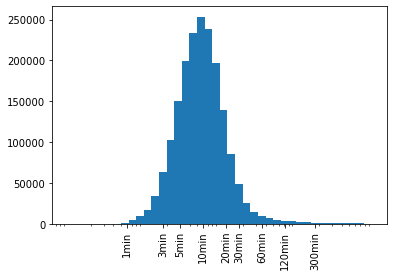

In [13]:
bin_edges = 10 ** np.arange(1, np.log10(df_copy.duration_sec.max())+0.1, 0.1)
plt.hist(df_copy.duration_sec, bins = bin_edges)
plt.xscale('log')
tick_locs = [60, 180, 300, 600, 1200, 1800, 3600, 7200, 18000]
tick_labels = ['1min','3min','5min','10min','20min','30min','60min','120min','300min']
plt.xticks(tick_locs, tick_labels, rotation=90);

可以观察到骑行时长大部分都在 1 小时以下，最多的位于 5-20 分钟的范围内，还是比较合理的。双变量探索时要探索会员与非会员分别的骑行时长分布。

#### 骑行开始时间探索

In [14]:
df_copy['start_date'] = df_copy['start_time'].dt.date
df_copy['start_week'] = df_copy['start_time'].dt.week
df_copy['start_weekday'] = df_copy['start_time'].dt.weekday
df_copy['start_hour'] = df_copy['start_time'].dt.hour
df_copy['start_month'] = df_copy['start_time'].dt.month

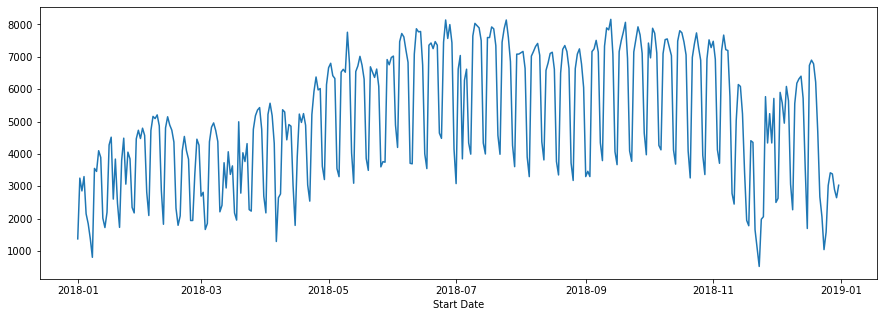

In [15]:
df_copy['start_date'].value_counts().sort_index().plot(figsize=(15,5))
plt.xlabel('Start Date');

可以看到明显的、有规律的波动，猜测是周末使用量下降导致的，看一下每周使用量是否与上面的波动相似：

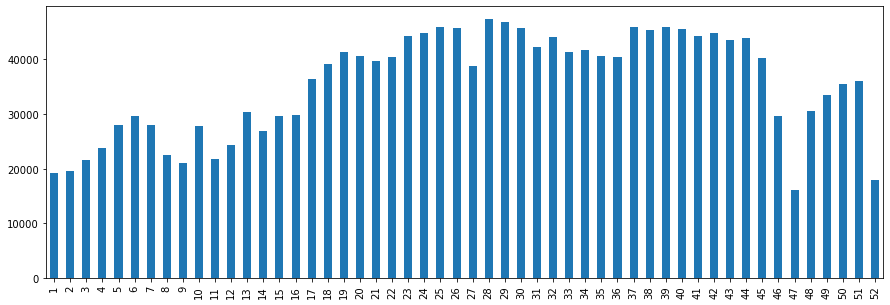

In [16]:
df_copy['start_week'].value_counts().sort_index().plot(kind='bar',figsize=(15,5));

每周的波动很可能是由于周末导致的，观察一下一周 7 天的变化情况：

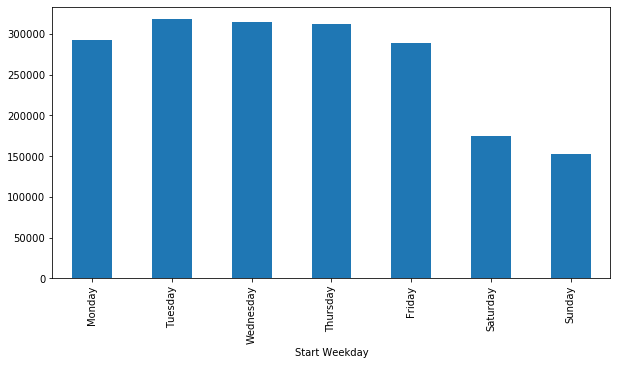

In [17]:
df_copy['start_weekday'].value_counts().sort_index().plot(kind='bar',figsize=(10,5))
# dayOfWeek={0:'Monday', 1:'Tuesday', 2:'Wednesday', 3:'Thursday', 4:'Friday', 5:'Saturday', 6:'Sunday'}
weekday_name = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
plt.xticks(range(0,7), weekday_name)
plt.xlabel('Start Weekday');

果然周末使用量减少很多，那么可能使用更多的是通勤的用途，可以探索一下小时的规律，看看能否与通勤挂钩：

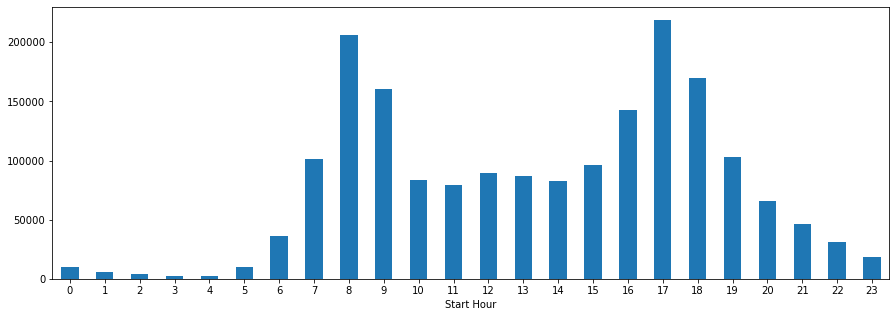

In [18]:
df_copy['start_hour'].value_counts().sort_index().plot(kind='bar',figsize=(15,5),rot=0)
plt.xticks(range(0,24), range(0,24))
plt.xlabel('Start Hour');

开始骑行的小时，可以发现明显的两个高峰，一个是 8-9 点，一个是 17-18 点，上下班高峰期。

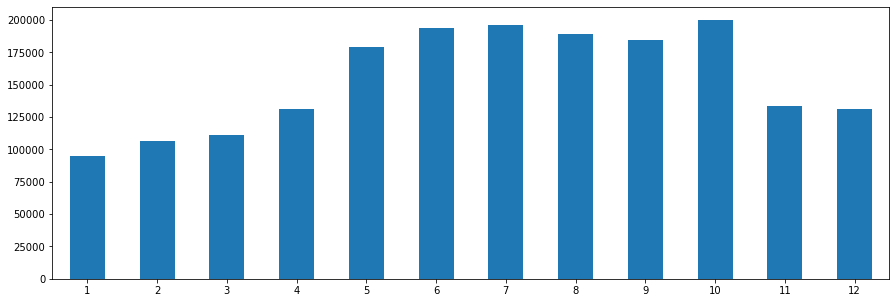

In [19]:
df_copy['start_month'].value_counts().sort_index().plot(kind='bar',figsize=(15,5),rot=0);

寒冷的月份使用量较少，5-10月使用量较多。

#### 用户类型分布

Subscriber    1574991
Customer       276959
Name: user_type, dtype: int64


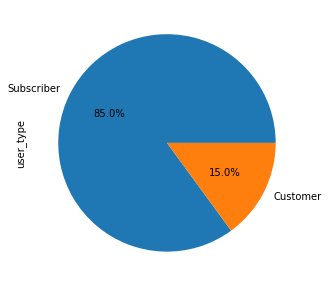

In [20]:
print(df_copy.user_type.value_counts())
df_copy.user_type.value_counts().plot(kind='pie', autopct='%.1f%%',figsize=(5,5));

In [21]:
# 创建布尔值类型的会员列，方便后续计算
df_copy['is_vip'] = df_copy['user_type'] == 'Subscriber'

In [22]:
df_copy['is_vip'].mean() #验证一下，与上面的饼图百分比一致

0.8504500661464942

大部分骑行订单来自会员账户，只有 11.4% 来自散客。

#### Bike Share for All 服务

Bike Share for All 这是一种服务方式，根据官网的介绍，似乎针对的是低收入人群，需要符合一些标准才可以申请，以下内容摘自[官网介绍](https://www.lyft.com/bikes/bay-wheels/bike-share-for-all):
> We offer all residents of the Bay Area an affordable, accessible, and fun new transportation option. Low-income residents qualify for a discounted membership.

>Bike Share for All is available to Bay Area residents ages 18 and older who qualify for Calfresh, SFMTA (Low Income) Lifeline Pass or PG&E CARE utility discount.

探索一下 2018 年这个服务的情况：

False    1690457
True      161493
Name: bike_share_for_all_trip, dtype: int64


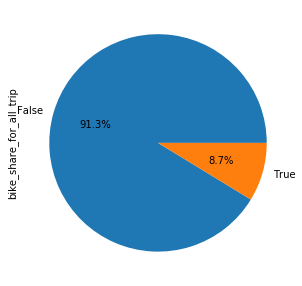

In [23]:
print(df_copy.bike_share_for_all_trip.value_counts())
df_copy.bike_share_for_all_trip.value_counts().plot(kind='pie', autopct='%.1f%%',figsize=(5,5));

只有 9.3% 的用户享用 Bike Share for All 服务。



### 对于你感兴趣的变量，存在什么异常吗？需不需要执行变换操作？

> 感兴趣的变量是分类变量，其实想要探索是否会员，可以直接将其转换为布尔值，方便后续的探索

### 在你探索的特征中，是否存在异常分布？你对这些数据执行了什么整理操作？请给出整理操作的原因。

> 探索的其他特征中，没有异常分布

## 双变量探索

In [24]:
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1851950 entries, 0 to 131362
Data columns (total 10 columns):
 #   Column                   Dtype         
---  ------                   -----         
 0   duration_sec             int64         
 1   start_time               datetime64[ns]
 2   bike_share_for_all_trip  bool          
 3   user_type                object        
 4   start_date               object        
 5   start_week               int64         
 6   start_weekday            int64         
 7   start_hour               int64         
 8   start_month              int64         
 9   is_vip                   bool          
dtypes: bool(2), datetime64[ns](1), int64(5), object(2)
memory usage: 130.7+ MB


#### 骑行时长 vs 会员

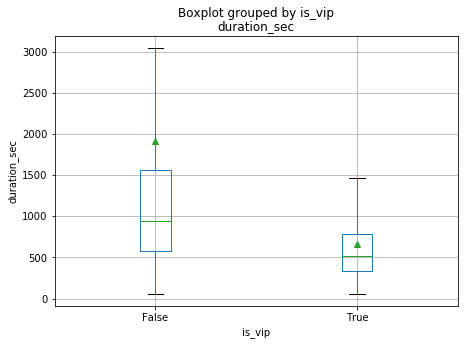

In [25]:
df_copy.boxplot(column='duration_sec',by='is_vip',showfliers=False, showmeans=True,figsize=(7,5))
plt.ylabel('duration_sec');

In [26]:
df_copy.groupby('is_vip')['duration_sec'].describe()

,count,mean,std,min,25%,50%,75%,max
is_vip,,,,,,,,
False,276959.0,1918.298532,5020.580956,61.0,581.0,946.0,1566.0,86366.0
True,1574991.0,665.668655,1329.790060,61.0,330.0,515.0,783.0,86281.0


从上面的箱线图和描述性统计信息可以看到，会员的骑行时长相对比较短，绝大多数都在 1500 秒以下，也就是小于 25 分钟。75% 的人骑行时长都在 13 分钟以下。

In [27]:
def duration_hist(df,label):
    bin_edges = 10 ** np.arange(1, np.log10(df_copy.duration_sec.max())+0.1, 0.1)
    df['duration_sec'].hist(bins=bin_edges,alpha=0.5,figsize=(7,5),label=label)
    plt.xscale('log')
    tick_locs = [60, 180, 300, 600, 1200, 1800, 3600, 7200, 18000]
    tick_labels = ['1min','3min','5min','10min','20min','30min','60min','120min','300min']
    plt.xticks(tick_locs, tick_labels, rotation=90)
    plt.xlabel('Duration')
    plt.ylabel('Number of users')
    plt.title('Duration vs Vip vs Count')
    plt.legend();

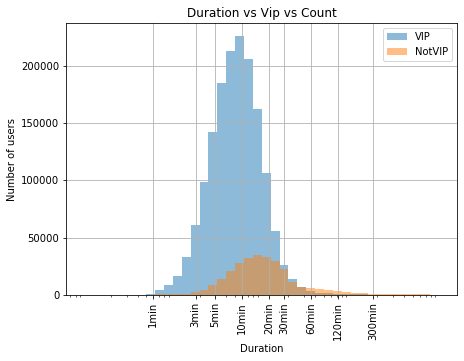

In [28]:
duration_hist(df_copy[df_copy['is_vip']==True],'VIP')
duration_hist(df_copy[df_copy['is_vip']==False],'NotVIP')

通过上方直方图对比，可以看到非会员的分布更加均匀且时长偏长，会员的时间非常集中在 3-20 分钟的范围内。
#### 会员  bike share for all 服务
因为关于会员的一些探索使用了类似的代码，所以整合为一个可以重复利用的函数：

In [29]:
def variable_visulization(df, feature):
    '''各个因素对注册会员的影响分析对比柱状图组合'''
    f, ax = plt.subplots(1,2,figsize=(18,5))
    # 左侧显示注册会员人数对比柱状图
    df1 = df.groupby([feature,'is_vip'])['is_vip'].count().unstack()
    df1.plot(kind='bar',ax=ax[0])
    ax[0].set_ylabel('Number of trips')
    ax[0].set_title(feature + ' VS Vip VS Count')
    # 右侧显示注册会员几率柱状图
    df2 = df.groupby(feature)['is_vip'].mean()
    df2.plot(kind='bar',ax = ax[1])
    ax[1].set_ylabel('Vip Rate')
    ax[1].set_title(feature + ' VS Vip Rate')
    for i, mean in enumerate(df2):
        ax[1].text(i+0.08, mean-0.03, round(mean, 3), 
                   horizontalalignment='center',rotation=90,color='white')
    plt.show()

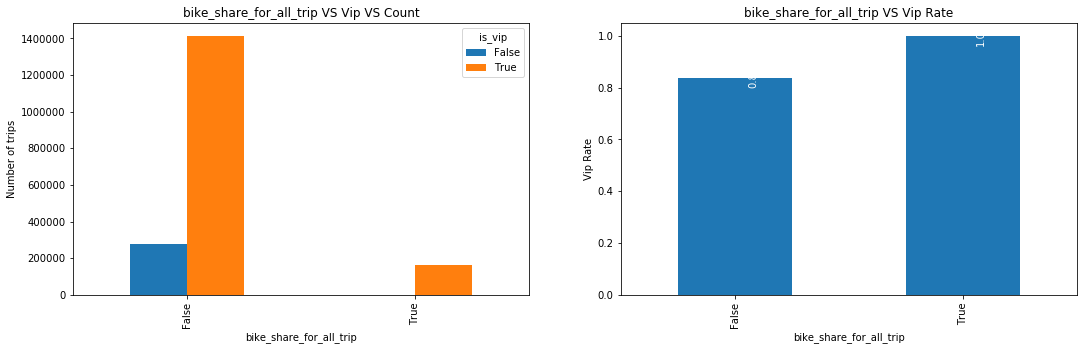

In [30]:
variable_visulization(df_copy,'bike_share_for_all_trip')

bike share for all 服务全部属于会员，可能是因为该服务也属于会员的一种。
#### 会员 vs 周

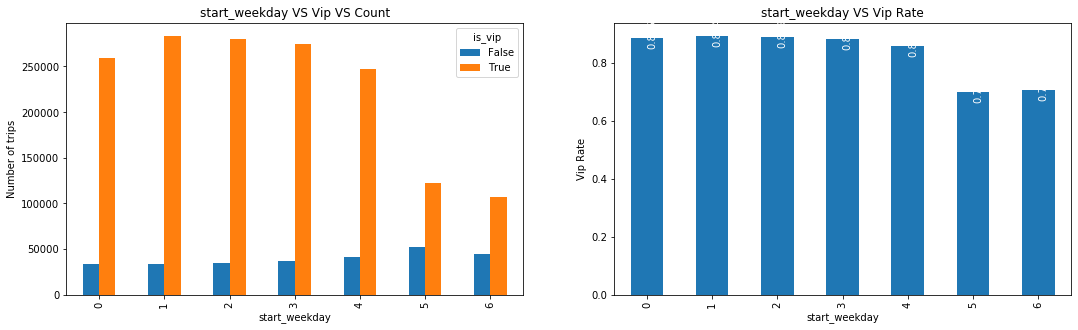

In [31]:
variable_visulization(df_copy,'start_weekday')

可以看到周末和工作日的表现呈现两种形式，创建一个新的变量 is_weekend，看看周末与非周末的直观差异：

In [32]:
df_copy['is_weekend'] = df_copy['start_weekday'].isin([5,6])

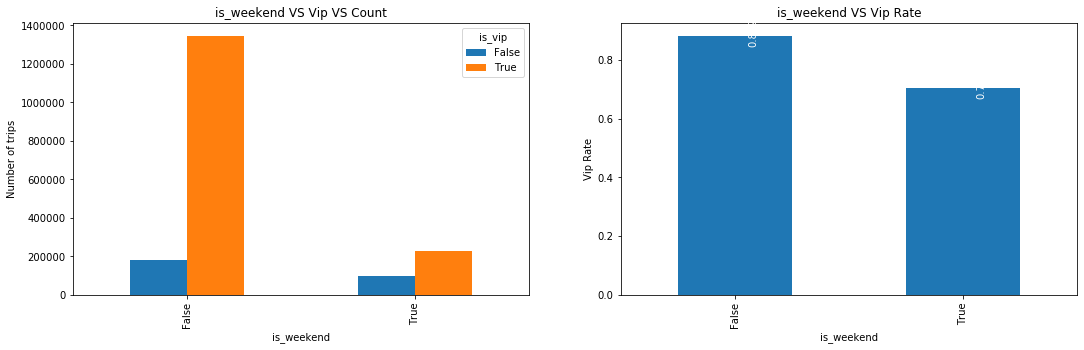

In [33]:
variable_visulization(df_copy,'is_weekend')

上图中可以看到，共享单车的使用，会员在工作日使用更多，非会员在周末使用更多，工作日的会员订单比例更多。这也比较符合认知，如果一个人通勤时需要使用共享单车，注册会员可能会更加划算；而周末使用的人很可能是偶然情况下使用。
#### 会员 vs 月

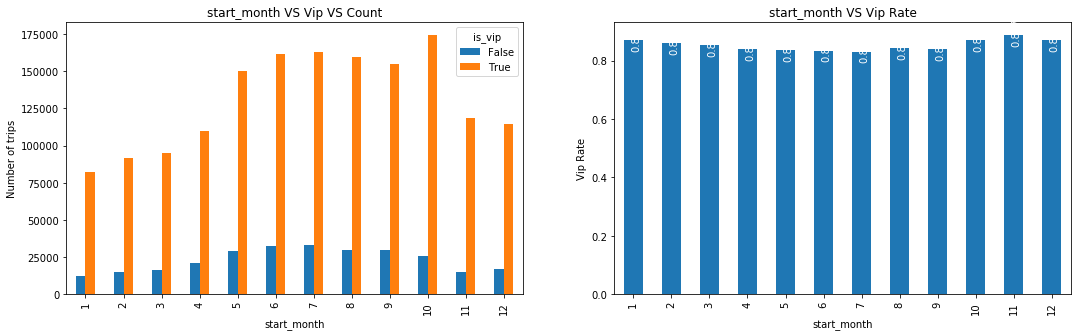

In [34]:
variable_visulization(df_copy,'start_month')

单变量探索中，发现的规律是寒冷的月份使用的比较少，这在上面左侧的图表中同样可以体现出来。每个月份的会员使用比例差异不是特别大，不过在相对寒冷的 1-4 月和 10-12 月，会员订单的比例是相对较高的，在寒冷的月份，会员仍有选择骑车的倾向，或许是习惯，或许是已经享受了订阅服务，不使用有点浪费？
#### 会员 vs 时

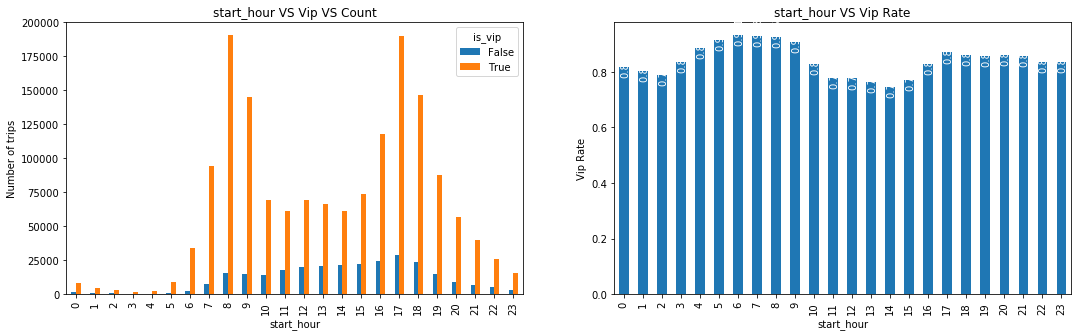

In [35]:
variable_visulization(df_copy,'start_hour')

可以看到共享单车会员的使用高峰与探索单变量时得出的结论一致，都是上下班高峰，但是非会员的分布就比较平滑，没有那么明显的差异。在右边的图表中也可以看出，会员在早晚高峰的使用率也是较多的。

#### 骑行时长 vs 是否周末
因为骑行时长与会员存在一定的相关性，而会员和是否为周末也存在一定的关系，所以再来看看骑行时长与周末是否有关系，先来看看箱线图的表现：

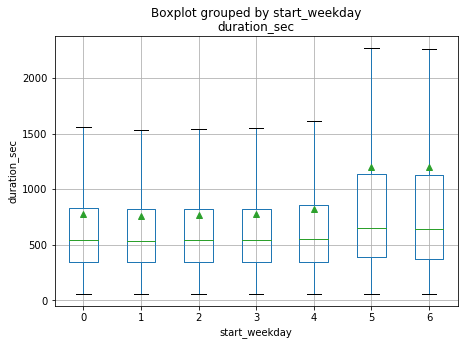

In [36]:
df_copy.boxplot(column='duration_sec',by='start_weekday',showfliers=False, showmeans=True,figsize=(7,5))
plt.ylabel('duration_sec');

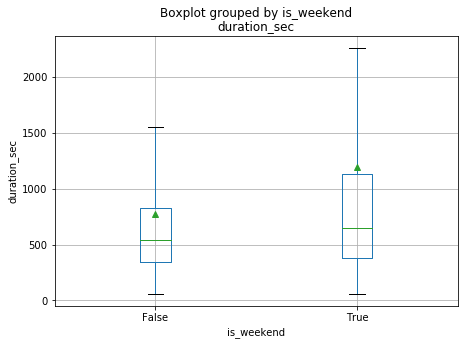

In [37]:
df_copy.boxplot(column='duration_sec',by='is_weekend',showfliers=False, showmeans=True,figsize=(7,5))
plt.ylabel('duration_sec');

两幅图表都表现出了，周末的骑行时长相对更长，而工作日骑行时长更短、时间更集中，可以看到周末的均值被一些较大的值拉到了较高的位置，与中位数的线距离较远。

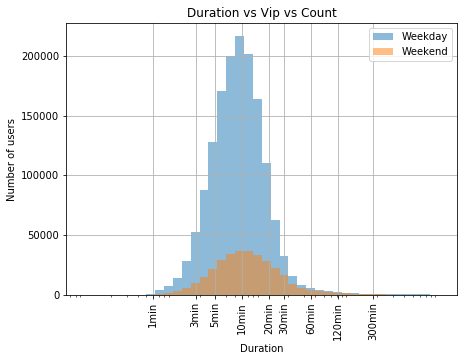

In [38]:
duration_hist(df_copy[df_copy['is_weekend']==False],'Weekday')
duration_hist(df_copy[df_copy['is_weekend']==True],'Weekend')

图中可以看到，工作日的骑行时长处于 5-20 min 的数据非常多，周末的数据分布则更为平均。

#### 是否周末 vs 骑行开始时间
猜测是否周末应该也与骑行开始的时间有关系，因为工作日的时间可能更接近通勤时间，看看可视化效果：

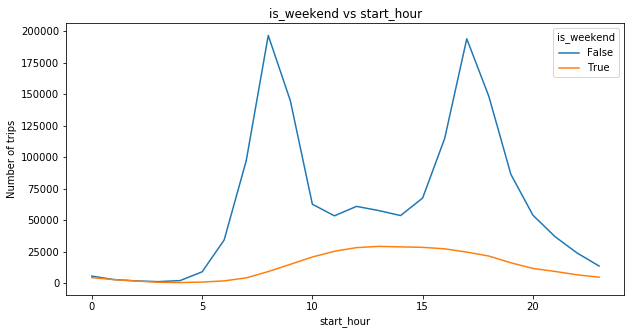

In [39]:
df_copy.groupby(['start_hour','is_weekend']).size().unstack().plot(figsize=(10,5))
plt.title('is_weekend vs start_hour')
plt.ylabel('Number of trips');

可以看到周末的数据非常平滑，是按照白天较多、夜晚较少的分布，而工作日正如想象的那样呈现了两个峰值：上下班的高峰期。

### 讲一下你在这一部分的探索中观察到的关系，你感兴趣的变量是否有变化？

> 观察到的关系：
- 会员的骑行时长相对更短，非会员的分布更加均匀且时长偏长，会员的时间非常集中在 3-20 分钟的范围内；
- 会员骑行更集中在工作日、通勤时间段，在寒冷的月份，比起非会员来说更有选择骑车的可能；
- 工作日的订单骑行时长更集中、更短，周末的骑行时长更为分散，相对时间较长。
- 工作日的订单更多发生在早晚高峰，周末白天的时间都比较均匀。

> 感兴趣的变量出现了变化，从更为具体的每周七天，归类为是否为周末，创建了新的变量 is_weekend。

### 是否观察到其他特征（不是之前感兴趣的特征）之间的有趣关系？

> 之前一直集中在是否为会员与其他特征的关系，在分析中发现了骑行开始的小时与是否周末也有关系。

## 多变量探索

> 创建三个或更多变量的图表，以进一步探索数据。确保探索是合理的，与前面的探索一脉相承。

这部分主要想探索的是会员与骑行时长和骑行发生的时间（是否为周末、通勤时间等）的关系，先创建一个可复用的函数：

In [40]:
def muliple_features(x,y="duration_sec",hue="is_vip"):
    plt.figure(figsize=(10,5))
    sns.boxplot(x=x, y=y, hue=hue,
                data=df_copy, palette="Set3",showfliers=False, showmeans=True)
    plt.title('{} vs {} vs {}'.format(x,y,hue))

#### 会员 vs 骑行时长 vs 周

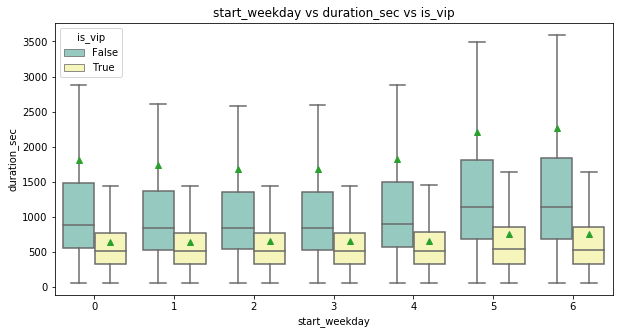

In [41]:
muliple_features("start_weekday")

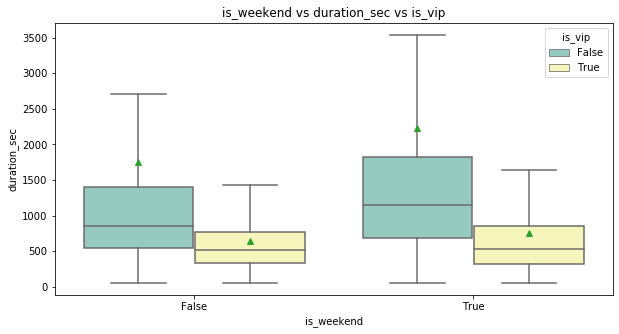

In [42]:
muliple_features("is_weekend")

通过上面两幅图表，明显可以看出，绿色的箱线更分散，均值更靠上。可以判断会员和非会员周末的骑行时长都相对更长，工作日都相对较短，而会员不论是周末还是工作日都比非会员的骑行时长更为集中。

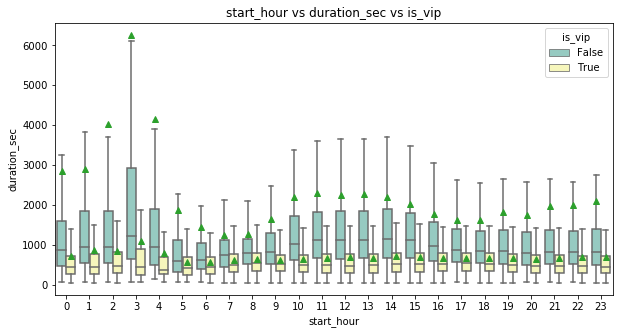

In [43]:
muliple_features("start_hour")

骑行开始时间，可以从均值看出夜晚和凌晨的时间波动比较大，会员的骑行时长一直都相对稳定，非会员在白天 10-16 点的时间段骑行时长比较长。下面将最感兴趣的四个变量放到一个图表中进行观察，这里选择了 seaborn 库的绘图方式，一方面是代码简练，另一方面还可以看到 95% 置信区间，观察到波动剧烈的凌晨数据。
#### VIP vs Start Hour vs Weekend vs Duration 折线图

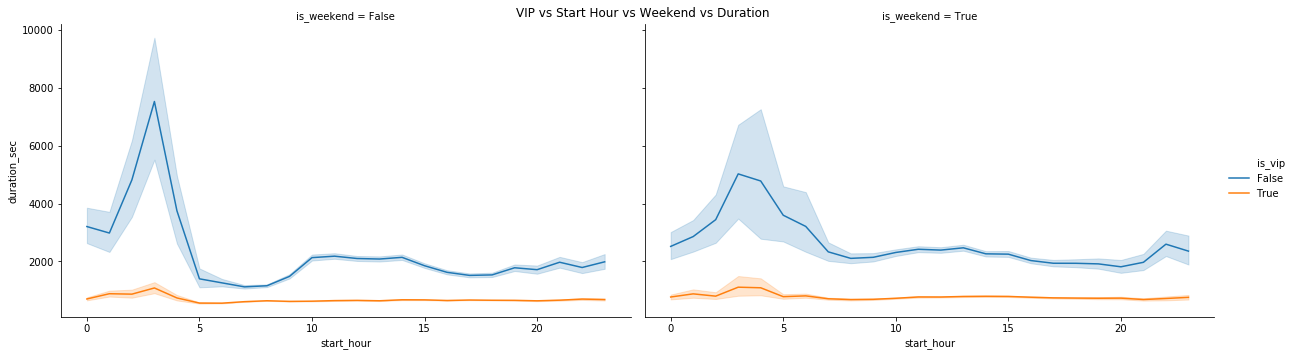

In [44]:
g = sns.relplot(x="start_hour", y="duration_sec", hue="is_vip", col="is_weekend", 
                height=5, aspect=12/7, facet_kws=dict(sharex=False),
                kind="line", legend="full", data=df_copy)
g.fig.suptitle('VIP vs Start Hour vs Weekend vs Duration', fontsize=12);

图中可以观察到，会员的折线波动都非常平滑，集中在较短的时间内，骑行时长的均值都维持在 1000 左右，也就是约 16 分钟左右。非会员的骑行时长均值维持在会员的折线上方，且波动较大，置信区间的范围也较大，说明数据较为分散。工作日和周末的对比不是特别明显，再绘制一份柱状图观察一下：

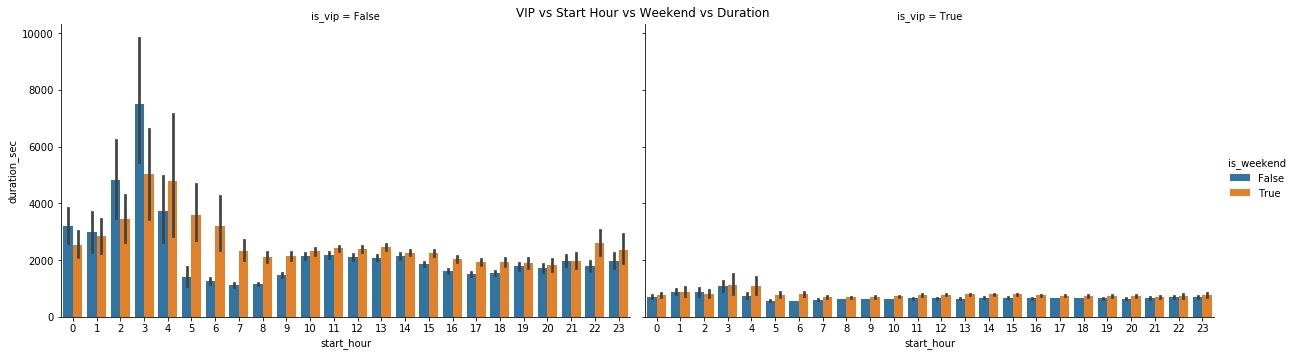

In [45]:
g = sns.catplot(x="start_hour", y="duration_sec", hue="is_weekend", col="is_vip",
                data=df_copy, kind="bar", height=5, aspect=12/7)
g.fig.suptitle('VIP vs Start Hour vs Weekend vs Duration',fontsize=12);

上图可以看到：
- 夜晚和凌晨的误差条都比较长，说明数据较为分散，没有那么明确的规律；
- 左右两个子图对比，可以看出左侧的长条都相对较高，说明非会员的骑行时长比会员的骑行时长要更长；
- 右侧会员的数据中，除了凌晨的个别时间段，基本上都处于 1000 以下，且误差条非常短，说明骑行时长集中，且时长都较短；
- 除了凌晨的个别时间段，基本上所有的橙色长条都比蓝色长条要高，说明基本上周末都比工作日的骑行时长要长；

### 讨论这一部分探索中观察到的关系。这些特征关系是否对你感兴趣的特征有帮助？ 

> 这一部分的探索验证了自己的猜想，非常有帮助。

### 特征之间是否存在有趣的、令人惊讶的相互作用？

> 共享单车的大部分用户都是会员，且主要的用途是短途通勤。所以订单数量、骑行时长，都会与工作日和通勤时间存在密切的联系。
会员这样的订阅服务，会在较为寒冷的月份体现出更明显的商业价值。